In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pprint import pprint
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.iolib import SimpleTable
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt, het_white, het_arch, acorr_ljungbox
from statistics import *
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit
from scipy.stats.stats import kurtosis, skew
from scipy.stats import boxcox
from IPython.core.display import display
from patsy import dmatrices
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from arch.univariate import ARX, ARCH, GARCH
import warnings
from datetime import datetime, timedelta
import seaborn as sns
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 15

In [2]:
df = pd.read_csv('./data/factors/RTSI.csv', parse_dates=['Date'], index_col='Date', dayfirst=True)
series = df['2009-01':'2019'].Close
series = series.resample('14d').last()
series2020 = df['2020':].Close

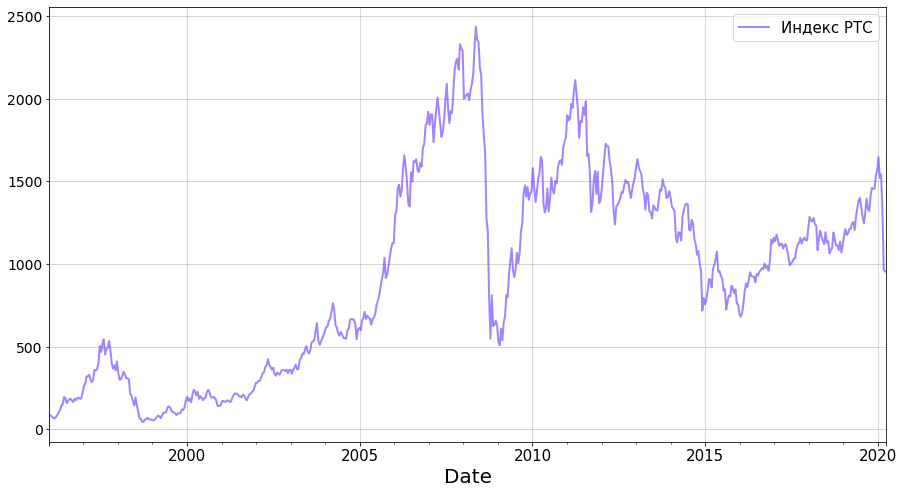

In [3]:
df.Close.resample('14d').last().plot(label='Индекс РТС', legend=True, linewidth=2, color='#63f9');

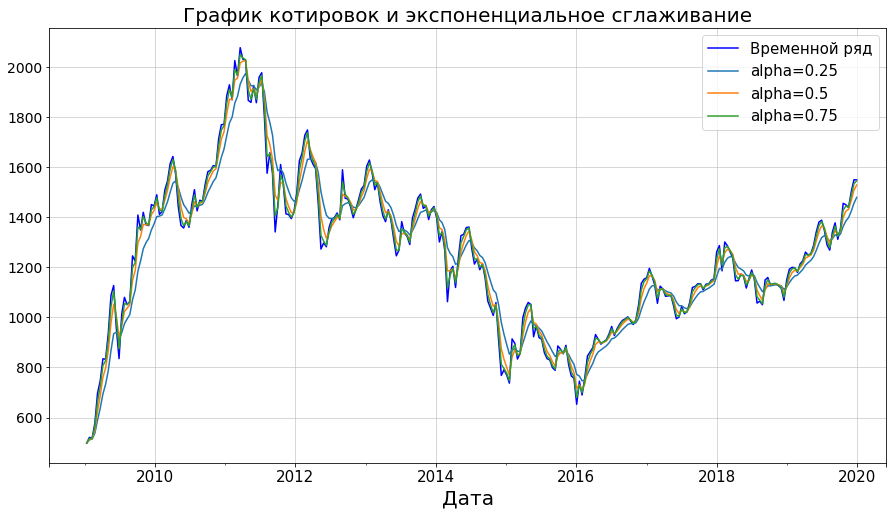

In [4]:
ax = series.plot(legend=True, color='blue', label='Временной ряд')
for alpha in [.25, .5, .75]:
    series.ewm(alpha=alpha).mean().plot(ax=ax, label=f'alpha={alpha}', legend=True)
ax.set_title('График котировок и экспоненциальное сглаживание')
ax.set_xlabel('Дата');
ax.set_xlim('2008-07', '2020-06')
del ax

### Тест Фуллера на стационарность ряда

In [229]:
fuller_test = adfuller(arima_by_partial_series_trend_remains.resid)
crit_value = fuller_test[4]

print(f'Т-статистика δ кф вспомогательного уравнения: {fuller_test[0]:.3f}')
print(f'p-value: {fuller_test[1]:.3f}')
print(f'Число наблюдений во вспомогательном уравнении: {fuller_test[3]}')
print(f'Критические значения T-статистики:')
print(f'  1%:  {crit_value["1%"]:.3f}')
print(f'  5%:  {crit_value["5%"]:.3f}')
print(f'  10%: {crit_value["10%"]:.3f}')

if fuller_test[0] > crit_value['1%']:
    print('Ряд нестационарен на 1%')
else:
    print('Ряд стационарен на 1%')

if fuller_test[0] > crit_value['5%']:
    print('Ряд нестационарен на 5%')
else:
    print('Ряд стационарен на 5%')
del fuller_test

Т-статистика δ кф вспомогательного уравнения: -17.044
p-value: 0.000
Число наблюдений во вспомогательном уравнении: 286
Критические значения T-статистики:
  1%:  -3.453
  5%:  -2.872
  10%: -2.572
Ряд стационарен на 1%
Ряд стационарен на 5%


In [ ]:
sm.tsa.seasonal_decompose(series.interpolate(), period=10).plot();

# Тренд 1 + ARMA на остатках

# Составление тренда 

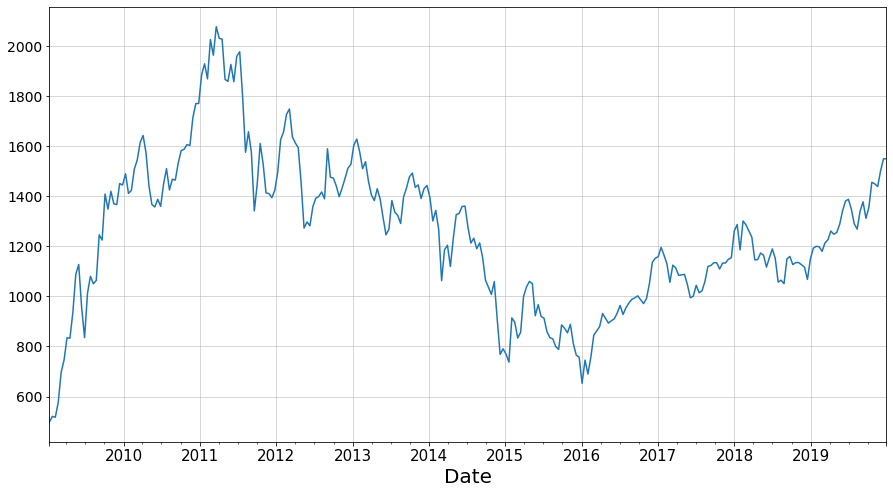

In [6]:
series.plot()

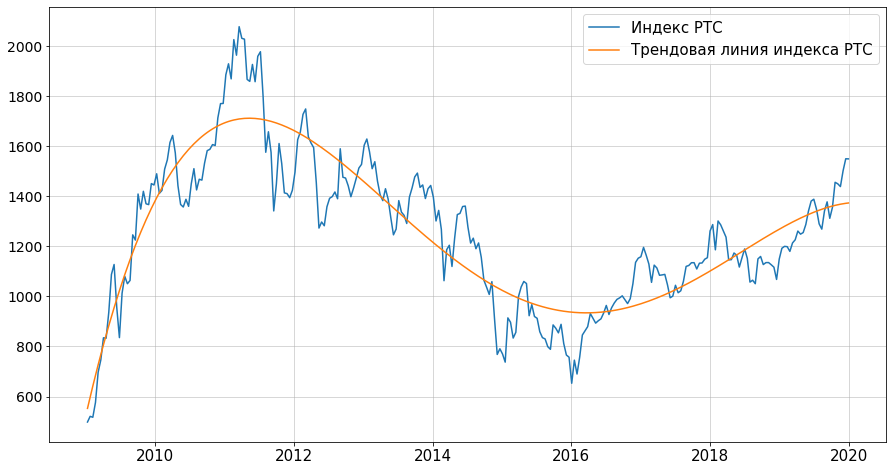

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     295.2
Date:                Thu, 07 May 2020   Prob (F-statistic):           1.78e-99
Time:                        20:20:44   Log-Likelihood:                -1809.5
No. Observations:                 287   AIC:                             3629.
Df Residuals:                     282   BIC:                             3647.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        506.4321     40.261     12.579      0.000     427.182     585.683
x1            46.8926      1.930     24.298      0.000      43.094      50.691
x2            -0.5844      0.027    -21.497      0.000      -0.638      -0.531
x3             0.0025      0.000     17.617      0.000       0.002       0.003
x4         -3.459e-06   2.44e-07    -14.172      0.000   -3.94e-06   -2.98e-06
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.658
Skew:                          -0.051   Prob(JB):                        0.720
Kurtosis:                       2.789   Cond. No.                     1.16e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
pf = PolynomialFeatures(degree=4)
xp = pf.fit_transform(np.arange(1, series.size+1)[:, np.newaxis])
series_trend_fitted_model = sm.OLS(series, xp).fit()

# plt.title('Данные и Тренд (Полиномиальный, 4 степени)')
plt.plot(series, label='Индекс РТС')

# Значения линии тренда
# Вместо .fittedvalues можно .predict(xp)
series_trend = series_trend_fitted_model.fittedvalues
series_remains = series_trend_fitted_model.resid
series_remains_exog = series_trend_fitted_model.model.exog

plt.plot(series_trend, label='Трендовая линия индекса РТС');
plt.legend()
plt.show()
display(series_trend_fitted_model.summary())


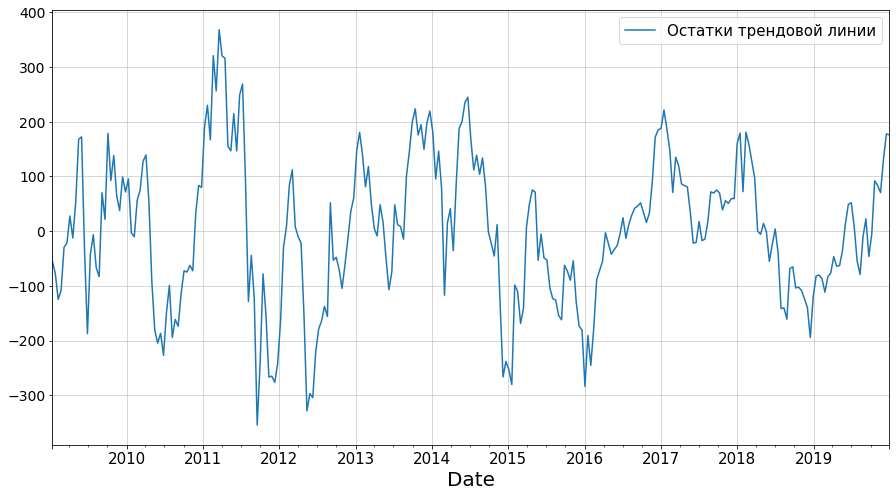

In [15]:
series_remains.plot(label='Остатки трендовой линии', legend=True);

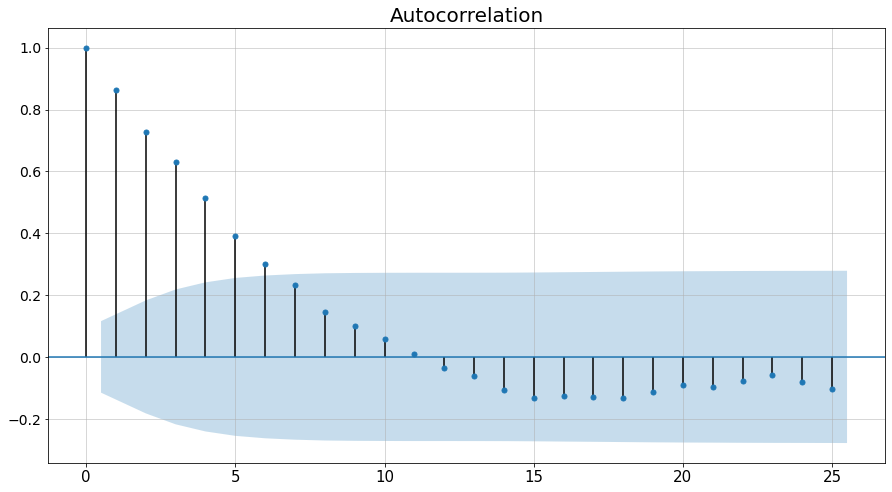

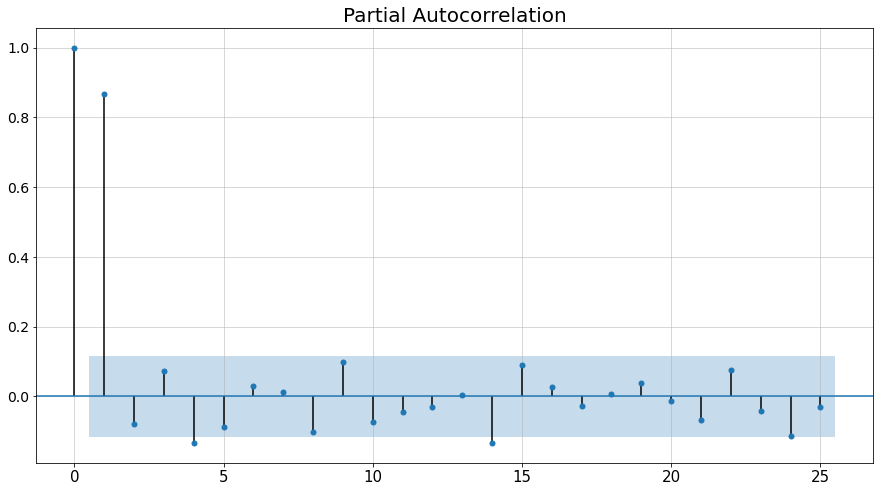

In [29]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
plot_acf(series_remains)
plot_pacf(series_remains);

In [34]:
# Лучшие pdq - 4, 0, 4
model = ARIMA(series_remains, order=(4, 0, 4))
arima_by_series_remains = model.fit()
display(arima_by_series_remains.summary())

del model

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  287
Model:                     ARMA(4, 4)   Log Likelihood               -1595.103
Method:                       css-mle   S.D. of innovations             62.215
Date:                Thu, 07 May 2020   AIC                           3210.206
Time:                        21:01:58   BIC                           3246.800
Sample:                    01-11-2009   HQIC                          3224.872
                         - 12-29-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5303      3.245      0.163      0.870      -5.831       6.891
ar.L1.y        1.1542      0.060     19.140      0.000       1.036       1.272
ar.L2.y       -0.4953      0.082     -6.054      0.000      -0.656      -0.335
ar.L3.y        1.1381      0.059     19.155      0.000       1.022       1.255
ar.L4.y       -0.8300      0.042    -19.720      0.000      -0.912      -0.748
ma.L1.y       -0.2428      0.085     -2.844      0.004      -0.410      -0.075
ma.L2.y        0.1402      0.048      2.899      0.004       0.045       0.235
ma.L3.y       -0.8960      0.066    -13.582      0.000      -1.025      -0.767
ma.L4.y       -0.0013      0.071     -0.018      0.985      -0.140       0.137
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3766           -0.9573j            1.0287           -0.3096
AR.2           -0.3766           +0.9573j            1.0287            0.3096
AR.3            1.0622           -0.1015j            1.0670           -0.0152
AR.4            1.0622           +0.1015j            1.0670            0.0152
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.4216           -0.9685j            1.0563           -0.3153
MA.3           -0.4216           +0.9685j            1.0563            0.3153
MA.4         -694.0691           -0.0000j          694.0691           -0.5000
-----------------------------------------------------------------------------
"""

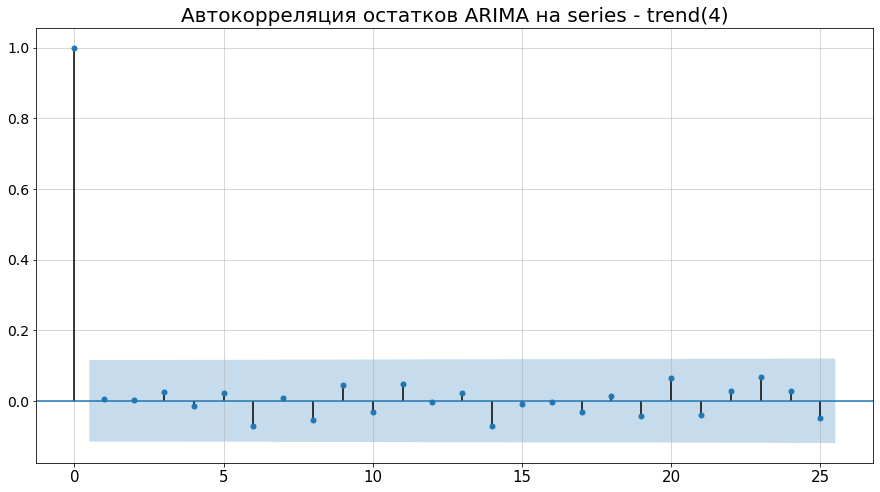

In [35]:
plot_acf(arima_by_series_remains.resid, title='Автокорреляция остатков ARIMA на series - trend(4)');

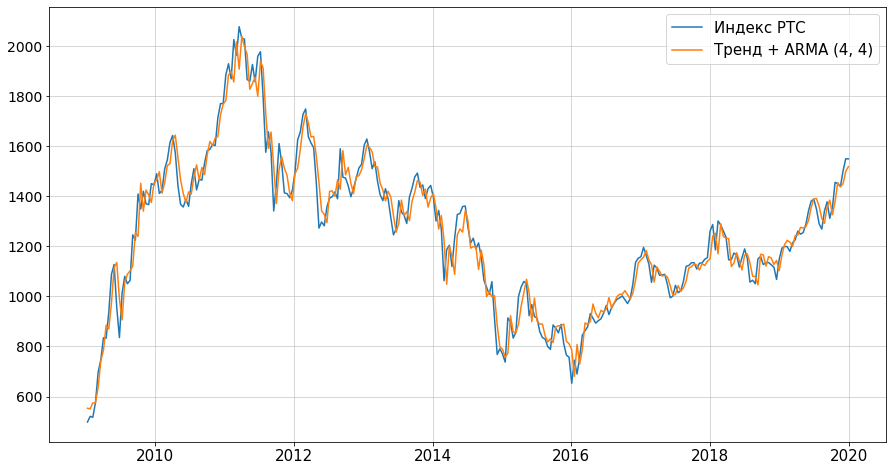

In [37]:
plt.plot(series, label='Индекс РТС');
plt.plot(series_trend + arima_by_series_remains.fittedvalues, label='Тренд + ARMA (4, 4)');
# plt.title('RTSI; Тренд + ARIMA на остатках от series - trend(4)')
plt.legend()
plt.show()

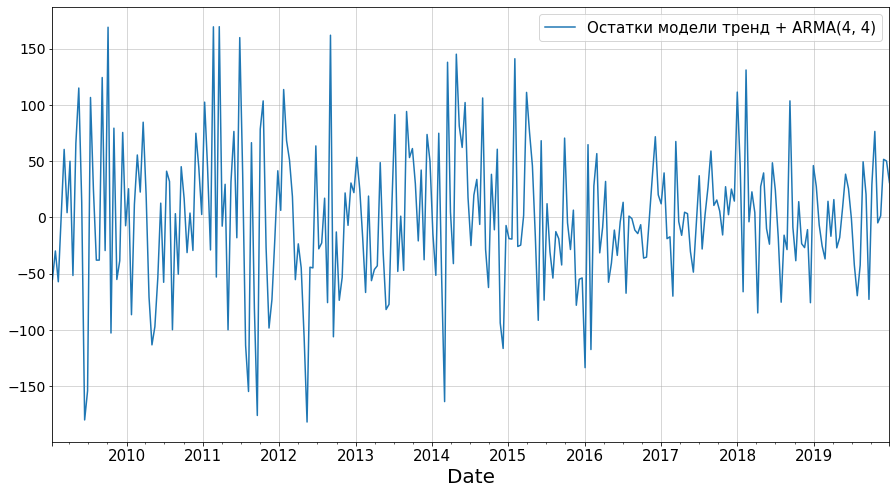

In [43]:
arima_by_series_remains.resid.plot(label='Остатки модели тренд + ARMA(4, 4)', legend=True);

# Проверка предпосылок регрессионного анализа (остатков от тренда)
#### - Нулевая средняя величина
#### - Остатки подчиняются нормальному распределению
#### - Случайный характер остатков
#### - Гомоскедастичность
#### - Отсутствие автокорреляции
#### (Некоторые тесты выводятся выше при составлении тренда (Дарбин-Уотсон)

## Нулевая средняя величина

In [227]:
print(f'Средняя величина остатков: {arima_by_partial_series_trend_remains.resid.mean():.4f}')

Средняя величина остатков: 0.2925


## 2)Остатки подчиняются нормальному распределению 

### На уровне значимости 0.05, нулевая гипотеза о нормальности распределения принимается

In [ ]:
display(SimpleTable(
    np.array([sm.stats.stattools.jarque_bera(series_remains)]),
     ['JB', 'p-value', 'skew', 'kurtosis']
))
# Гипотеза Н0 - о нормальном распределении остатков
# Чем ближе распределение ошибок к нормальному, тем меньше статистика Харке—Бера отличается от нуля.
#При достаточно большом значении статистики p-value будет мало,
#и тогда будет основание отвергнуть нулевую гипотезу (статистика попала в «хвост» распределения). 

### Критерии ассиметрии и эксцесса, и РС

In [233]:
kurt = kurtosis(arima_by_partial_series_trend_remains.resid)
n = arima_by_partial_series_trend_remains.resid.size
kurt_critical = 5*(24*n*(n-2)*(n-3)/(n+1)**2/(n+3)/(n+4))**.5
sk = skew(arima_by_partial_series_trend_remains.resid)
sk_critical = 3*(6*(n-1)/(n+1)/(n+3))**.5

if kurt < kurt_critical:
    print(f'Эксцесс {kurt:.4f} меньше критического {kurt_critical:.4f}')
else:
    print(f'Эксцесс {kurt:.4f} больше, либо равен критическому {kurt_critical:.4f}')

if sk < sk_critical:
    print(f'Ассиметрия {sk:.4f} меньше критического {sk_critical:.4f}')
else:
    print(f'Ассиметрия {sk:.4f} больше, либо равна критической {sk_critical:.4f}')
    
rem = arima_by_partial_series_trend_remains.resid
# Полученное значение сравнивается с табличными 
# С вероятностью ошибки-0.05 и длиной выборки-100 РС критерий должен быть в диапазон(4.31; 5.9)
rc = (rem.max() - rem.min()) / ((rem**2).sum()/len(rem)-1)**.5
print(f'РС критерий: {rc:.4f}')

if kurt < kurt_critical and sk < sk_critical and 4.3 < rc < 5.9:
    print('Вывод: Остатки распределены нормально')
else:
    print('Вывод: Остатки не распределены нормально')

Эксцесс 0.3434 меньше критического 1.4111
Ассиметрия -0.0459 меньше критического 0.4300
РС критерий: 5.7532
Вывод: Остатки распределены нормально


## 3)Случайный характер остатков 

In [ ]:
fuller_test = adfuller(series_remains)
if fuller_test[0] > fuller_test[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
del fuller_test
#H0 - наличие единичного корня т.е. нестационарность ряда
# Если p-value (второе значение теста) больше критического (0.05), то мы не можем отвергнуть нулевую гипотезу
# + проверяем значение самого теста. Если значение > критического от 5%, то ряд нестационарен.

## 4)Гомоскедастичность

In [ ]:
bp_test = het_breuschpagan(series_remains, series_remains_exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels, bp_test)))
# H0 - наличие гомоскедастичности. Если оба p-value меньше 0.05 - гетероскедастичность

In [ ]:
het_goldfeldquandt(series_remains, series_remains_exog, store=True)
# H0 - о равенстве дисперсий в двух подвыборках (гомоскедастичность)
# Смотрим на второе число (p-value) - p-value гипотезы что дисперсии отличаются. Если большое, то гетероскедастичность

### Тест Уайта

### F-критическое ищется по таблице F(0.01; 13, 120) = 3.255

### 5.94 > F критическое => уравнение значимое => гетероскедастичность

### Если последнее число(значимость F) < 0.05 => гетероскедастичность

In [ ]:
#1 вариант - использует дисперсии
white_test = het_white(series_remains, series_remains_exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels, white_test)))
# Тест аналогичен с бройшем паганом

### Тест Уайта вручную (другой вариант теста)

### При гетероскедастичности все полученные члены будут значимы и p-value>0.05

In [ ]:
tmp = series_remains.to_frame()
tmp['t'] = np.arange(tmp.size)
tmp['t2'] = tmp.t ** 2
tmp['t3'] = tmp.t ** 3
tmp['t4'] = tmp.t2 ** 2
tmp['t22'] = tmp.t2.copy()
tmp['t44'] = tmp.t4.copy()
tmp['t6'] = tmp.t3 ** 2
tmp['t8'] = tmp.t4 ** 2

tmp['a'] = tmp.t3.copy()
tmp['b'] = tmp.t4.copy()
tmp['c'] = tmp.t4 * tmp.t
tmp['d'] = tmp.t4 * tmp.t
tmp['e'] = tmp.t3 ** 2
tmp['f'] = tmp.t3 * tmp.t4
tmp['remains'] = series_remains ** 2

In [ ]:
f = smf.ols('remains ~ (t + t2 + t3 + t4 + t22 + t44 + t6 + t8 + a + b + c + d + e + f)', data=tmp).fit()
display(f.summary())
del tmp

### Тест парка на гомоскедастичность

### Гетероскедастичность если полученные уравнение по F-критерию значимы и значимый КФ при ln фактора

In [ ]:
tmp = series.to_frame()
tmp['t'] = np.log(np.arange(1, series.size+1))
tmp['t2'] = np.log(np.arange(1, series.size+1)**2)
tmp['t3'] = np.log(np.arange(1, series.size+1)**3)
tmp['t4'] = np.log(np.arange(1, series.size+1)**4)
tmp['Close2'] = np.log(series_remains ** 2)
tmp

In [ ]:
smf.ols('Close2 ~ t', data=tmp).fit().summary()

In [ ]:
smf.ols('Close2 ~ t2', data=tmp).fit().summary()

In [ ]:
smf.ols('Close2 ~ t3', data=tmp).fit().summary()

## 5)Проверка автокорр.

### Сравниваем эту T-статистику КФ автокорр. с T-табличным 
### (если |Tрасч|>Tтабл, то отклоняем H0 о незначимости коэф)

In [ ]:
plot_acf(series_remains);

In [ ]:
_kf = acf(series_remains, fft=False)[1]
t = (((_kf**2) * (series.size-2)) / (1-_kf**2))**.5

In [230]:
print(f'Durbin-Watson = {durbin_watson(arima_by_partial_series_trend_remains.resid):.3f}')

Durbin-Watson = 1.997


In [ ]:
#Смотрим на зону, в которую попадает это число. (Если меньше примерно 1.5, то положительная автокорреляция)
durbin_watson(series_remains)

# Проверка остатков после (trend + Arima) 

In [ ]:
q_test = acf(arima_by_series_remains.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();
del q_test, q_df

In [ ]:
acorr_ljungbox(arima_by_series_remains.resid, return_df=True)
# H0 - данные являются "белым шумом"
# Также можно сверить Q статистику с таблицей распределения ХИ-КВАДРАТ

### Остатки полученные после тренд + ARIMA по критерию бокса-льюинга являются белым шумом (поскольку все p-value до 40 лага >0.05)

### Прогноз тренд (1) + ARMA (4, 4)

In [55]:
_ = []
for i in range(1, 300):
    _.append(5.06432082e+02 + 4.68925631e+01*i - 5.84355075e-01*(i**2) + 2.49624085e-03*(i**3) -3.45926525e-06*(i**4))

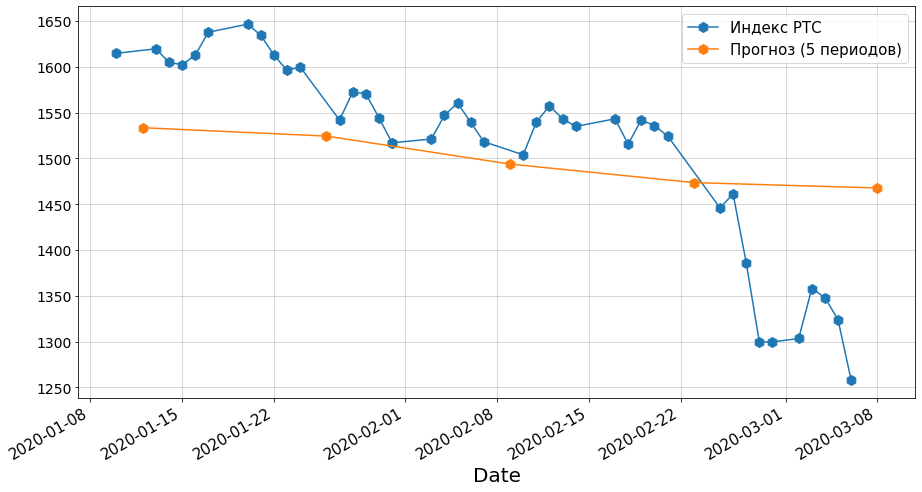

In [95]:
series2020['2020-01-10':'2020-03-06'].plot(marker='h', markersize=10, label='Индекс РТС')
(arima_by_series_remains.predict('2020', '2020-03') + _[287:292]).plot(marker='h', markersize=10, label='Прогноз (5 периодов)')
plt.legend()
plt.show();

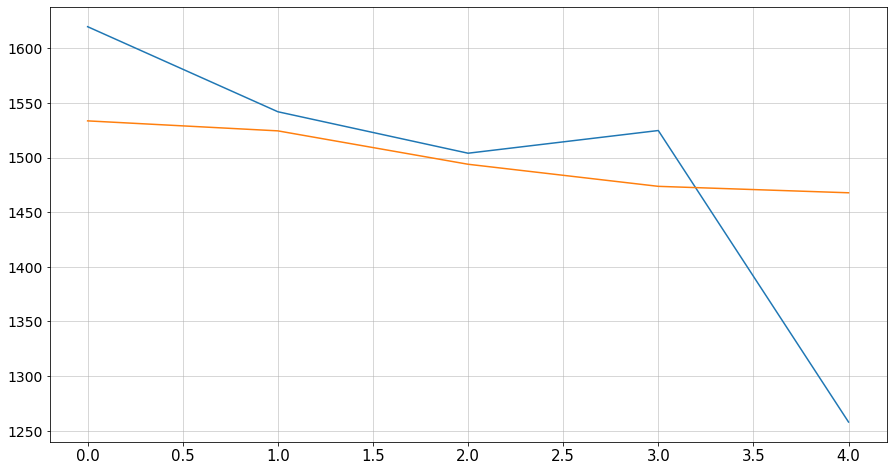

In [56]:
plt.plot(series2020[series2020.index.isin(['2020-01-13', '2020-01-27', '2020-02-10', '2020-02-21', '2020-03-06'])].to_numpy())
plt.plot((arima_by_series_remains.predict('2020', '2020-03') + _[287:292]).to_numpy());

In [57]:
r2_score(
    series2020[series2020.index.isin(['2020-01-13', '2020-01-27', '2020-02-10', '2020-02-21', '2020-03-06'])].to_numpy(),
    (arima_by_series_remains.predict('2020', '2020-03') + _[287:292])
)

0.2716538687604373

## ARIMAX с факторами из регрессионного анализа

In [ ]:
factors_dir = os.path.join('data', 'factors')

def read_csv(*args, **kwargs):
    kwargs.setdefault('parse_dates', ['Date'])
    kwargs.setdefault('index_col', 'Date')
    res = pd.read_csv(*args, **kwargs)
    if res.size < 50:
        res = res.resample('1y').last()
    elif res.size < 600:
        res = res.resample('1m').last()
    else:
        res = res.append(res.resample('1m').last())
    return res


# Создание series'ов и dataframe'ов
factors_csv = os.listdir(factors_dir)
for csv_file in factors_csv:
    if csv_file.startswith('.') or not csv_file.endswith('.csv'):
        continue
    var_name = os.path.splitext(csv_file)[0].lower()
    df_name = f'{var_name}_df'
    series_name = f'{var_name}_series'
    globals()[df_name] = read_csv(os.path.join(factors_dir, csv_file))
    globals()[series_name] = globals()[df_name].Close.resample('1d').last().dropna()
    
all_df = pd.DataFrame({
    # Индекс РТС
    'RTSI': rtsi_series,
    # Индекс S&P 500
    'SP500': sp500_series,
    # FTSE - Англия
    'FTSE': ftse_series,
    # DAX - Германия
    'DAX': dax_series,
    # SSE - Китай
    'SSE': sse_series,
    # Нефть Brent
    'Brent': brent_series,
    # USD/RUB
    'USD': usd_series,
    # Темпы роста ВВП РФ
    # 'GDP': gdp_series,
    # Золото
    'Gold': gold_series,
    # Уровень безработицы в РФ
    'Unemployment': unemployment_series,
    # Индекс потребительских цен
    # 'CPI': cpi_series,
    # Индекс потребительских цен погодично
    # 'CPI_year': cpi_year_series,
    # Индекс потребительских цен относительно 2000 года
    # 'CPI2000': cpi2000_series,
    # Индекс потребительских цен относительно 1996 года
    # 'CPI1996': cpi1996_series,
    # Ставки по межбанковским кредитам
    'InterbankRate': interbank_rate_series,
    # Доходность 6 месячных облигаций США
    'USA6mBond': usa_6m_bond_series,
    # Инвестиции в основной капитал
    # 'capital_investment': capital_investment_series,
    # Внешняя торговля РФ
    'international_trade': international_trade_series,
    # Индекс производительности труда
    'labor_performance': labor_performance_series,
    # Индекс промышленного производства
    'industrial_production': industrial_production_series,
    # Ключевая ставка
    'key_rate': key_rate_series,
    # Остатки на корреспондентских счетах
    # 'correspondent_accounts': correspondent_accounts_series,
    # Остатки на корреспондентских счетах (средние скорректированные)
    'correspondent_accounts_mean_scorr': correspondent_accounts_mean_scorr_series,
    # Номинальная зарплата
    # 'nominal_salary': nominal_salary_series,
    # Скорректированная номинальная зарплата
    'nominal_salary_scorr': nominal_salary_scorr_series,
    # ВВП РФ в абсолютном значении
    # 'abs_gdp': abs_gdp_series,
    # Скорректированный ВВП РФ в абсолютном значении
    'abs_gdp_scorr': abs_gdp_scorr_series,
    # Скорректированные инвестиции в основной капитал
    'capital_investment_scorr': capital_investment_series
})

In [ ]:
test_df2 = all_df['2009':'2019'].resample('14d').last().copy()
arimax = sm.tsa.statespace.SARIMAX(
    test_df2['RTSI'], order=(1,1,1), seasonal_order=(0,0,0,0), exog=test_df2[['Brent', 'SP500']]
).fit()
arimax.summary()

In [ ]:
test_df2.RTSI.plot()
arimax.fittedvalues.plot();

In [ ]:
arimax.resid.plot()

### Прогноз

In [ ]:
arimax_predict = arimax.predict(
    '2020-01-01', '2020-02-15',
    exog=all_df[['Brent', 'SP500']]['2020':].resample('14d').last()[:5]
)
r2_score(
    rtsi_series['2020':].resample('14d').last()[:5], arimax_predict
)

# ARIMA на исходные данные 

In [ ]:
plot_acf(np.diff(series), lags=20)
plot_pacf(np.diff(series), lags=20);

In [ ]:
# r = Arima.find_optimal_model_by_order(series, [2,3,8], 1, [2,3,8], top=9)

In [ ]:
# for i in r:
#     print(i.order, i.aic)

In [ ]:
arima_by_series = ARIMA(series, order=(2, 1, 2)).fit()

In [ ]:
plt.plot(series, label='Индекс РТС')
plt.plot(series - arima_by_series.resid, label='ARIMA (2,1,2)')
# plt.title(f'Арима {arima_by_series.k_ar}, {arima_by_series.k_diff}, {arima_by_series.k_ma} на данные')
plt.legend(fontsize=15)
plt.show()

plt.plot(
    arima_by_series.resid,
    label=f'ARIMA ({arima_by_series.k_ar}, {arima_by_series.k_diff}, {arima_by_series.k_ma}) Residuals'
)
plt.legend(fontsize=17)
plt.show();
arima_by_series.summary()

In [ ]:
(arima_by_series.fittedvalues + arima_by_series.resid).plot();

### Проверим остатки от этой ARIMA на белый шум

In [ ]:
plt.plot(arima_by_series.resid, label='Остатки аримы');

In [ ]:
q_test = acf(arima_by_series.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();
del q_test, q_df

In [231]:
lb_df = acorr_ljungbox(arima_by_partial_series_trend_remains.resid, return_df=True, lags=20)
lb_df['Quantile χ2(0.05)'] = [3.8, 6.0, 7.8, 9.5, 11.1, 12.6, 14.1, 15.5, 16.9, 18.3, 19.7, 21.0, 22.4, 23.7, 25.0, 26.3, 27.6, 28.9, 30.1, 31.4]
lb_df

,lb_stat,lb_pvalue,Quantile χ2(0.05)
1,0.006726,0.934639,3.8
2,0.258982,0.878543,6.0
3,0.543116,0.909322,7.8
4,0.547848,0.968679,9.5
5,2.055522,0.841410,11.1
6,2.919609,0.818867,12.6
7,2.984324,0.886449,14.1
8,3.315377,0.913037,15.5
9,3.930627,0.915919,16.9
10,4.368572,0.929192,18.3


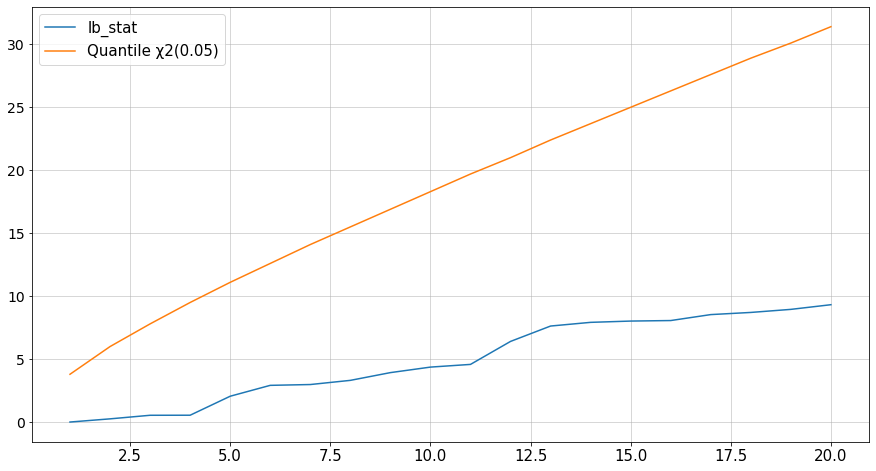

In [232]:
lb_df[['lb_stat', 'Quantile χ2(0.05)']].plot();

In [ ]:
acorr_ljungbox(arima_by_series.resid, return_df=True)
# H0 - данные являются "белым шумом"
# Также можно сверить Q статистику с таблицей распределения ХИ-КВАДРАТ

### Прогноз

In [241]:
start = series[-1]
predicted = arima_by_series.predict('2020', '2020-03')
for i in range(len(predicted)):
    predicted[i] += start
    start = predicted[i]

plt.plot(series, label='Данные')
plt.plot((series - arima_by_series.resid).append(predicted), label='Предикт')
plt.legend()
plt.show();

NameError: name 'arima_by_series' is not defined

In [ ]:
series2020 = df['2020':].Close
predicted2020 = (series - arima_by_series.resid).append(predicted)
predicted2020 = predicted2020['2020':]

In [ ]:
predicted.values

In [ ]:
plt.plot(
    series2020[series2020.index.isin(['2020-01-13', '2020-01-27', '2020-02-10', '2020-02-21', '2020-03-06'])].values)
plt.plot(
    predicted.values
);

In [240]:
ser1 = series2020[series2020.index.isin(['2020-01-13', '2020-01-27', '2020-02-10', '2020-02-21', '2020-03-06'])]
ser2 = pd.Series(data=predicted.values, index=ser1.index)
r2_score(ser1.to_numpy(), ser2.to_numpy())

NameError: name 'predicted' is not defined

In [ ]:
plt.plot(series2020['2020-01-12':'2020-03-08'], label='Индекс РТС', marker='o')
plt.plot(predicted, label='Прогноз (5 периодов)', marker='s')
plt.plot(pd.Series(map(lambda x: x[0], arima_by_series.forecast(5)[2]), index=predicted.index))
plt.plot(pd.Series(map(lambda x: x[1], arima_by_series.forecast(5)[2]), index=predicted.index))
plt.fill_between(
    predicted.index, 
    pd.Series(map(lambda x: x[0], arima_by_series.forecast(5)[2]), index=predicted.index),
    pd.Series(map(lambda x: x[1], arima_by_series.forecast(5)[2]), index=predicted.index),
    color=((.3, .3, .3, .2), )
)
plt.xticks(rotation=20)
plt.legend();

## Тест CHOW

In [187]:
rss_total = ((series - series_trend.mean())**2).sum()

In [255]:
nom = (rss_total - rss1 - rss2 - rss3)/(3+3+3-4)
denom = (rss1 + rss2 + rss3)/(287-9)
nom/denom

12.280902397499107

In [ ]:
# Оптимальный '2011-10-31' / '2016-03-31'
#chow_test_result, split_point1, partial_series = \
#     Model(series['2011-06': ] ).cut_by_chow_test(arbitrarily=2, with_result=True)
#draw(partial_series)

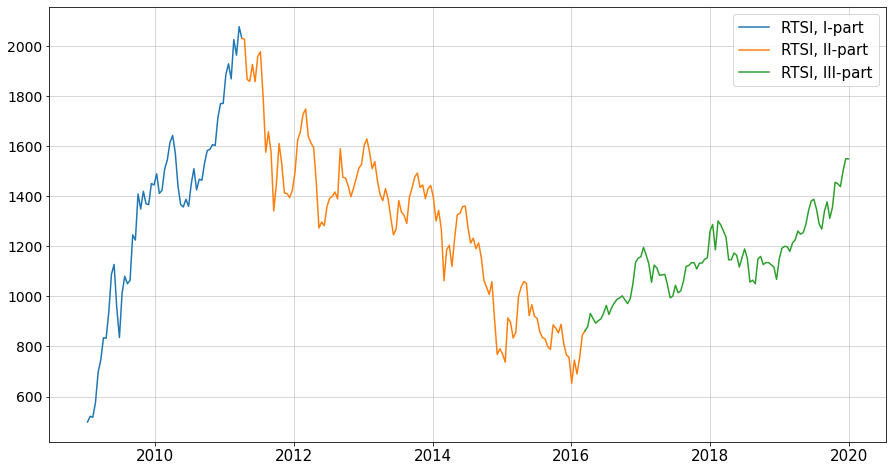

In [211]:
partial_series = PartialModel(series[:'2011-03'], series['2011-04':'2016-02'], series['2016-03':])
draw(partial_series)
plt.legend(['RTSI, I-part', 'RTSI, II-part ', 'RTSI, III-part'])
plt.show()

### 1-ый кусок

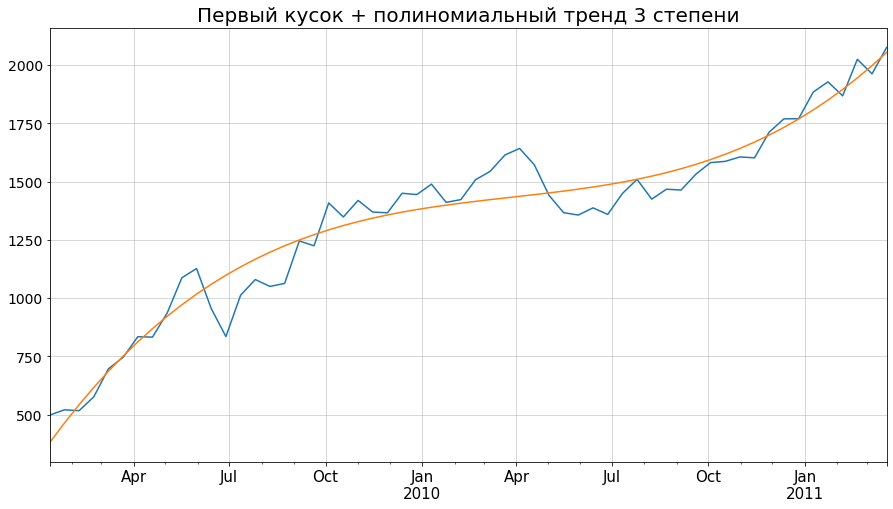

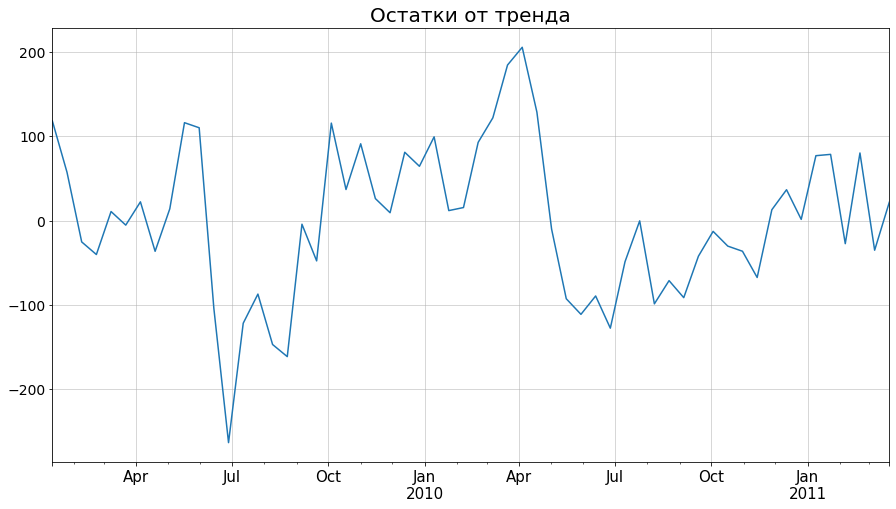

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     314.1
Date:                Fri, 08 May 2020   Prob (F-statistic):           3.82e-34
Time:                        01:25:23   Log-Likelihood:                -342.83
No. Observations:                  58   AIC:                             693.7
Df Residuals:                      54   BIC:                             701.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        291.3398     51.926      5.611      0.000     187.234     395.445
x1            91.2751      7.557     12.078      0.000      76.124     106.426
x2            -2.5905      0.296     -8.744      0.000      -3.184      -1.997
x3             0.0266      0.003      8.046      0.000       0.020       0.033
==============================================================================
Omnibus:                        0.804   Durbin-Watson:                   0.715
Prob(Omnibus):                  0.669   Jarque-Bera (JB):                0.357
Skew:                          -0.173   Prob(JB):                        0.837
Kurtosis:                       3.169   Cond. No.                     3.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [149]:
partial_series.p1.plot()
partial_series.p1.polynomial_trend(3).plot()
plt.title('Первый кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p1.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p1.polynomial_trend(3).fitted_model.summary())

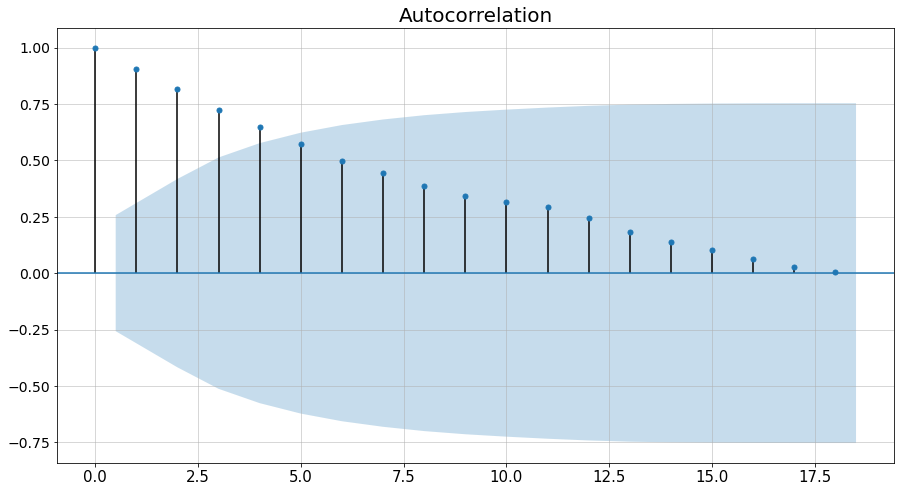

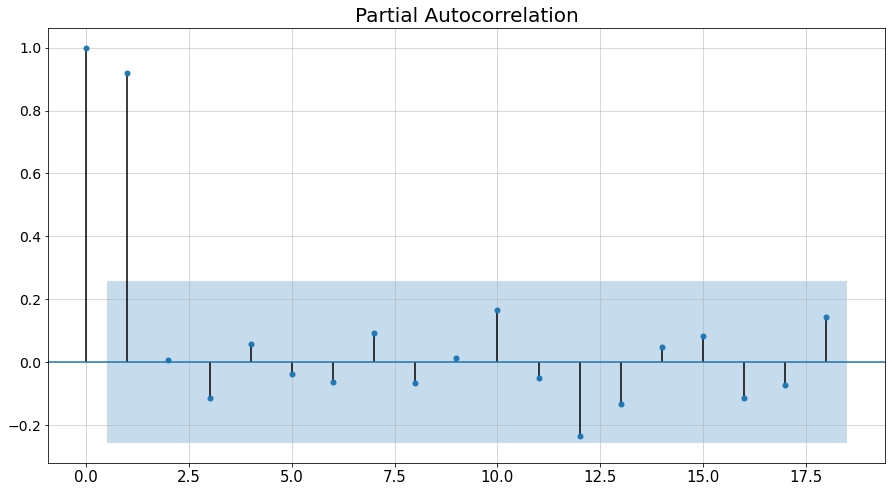

In [150]:
plot_acf(partial_series.p1)
plot_pacf(partial_series.p1);

In [186]:
rss1 = ((partial_series.p1.polynomial_trend(3) - partial_series.p1.mean())**2).sum()

### 2-ой кусок 

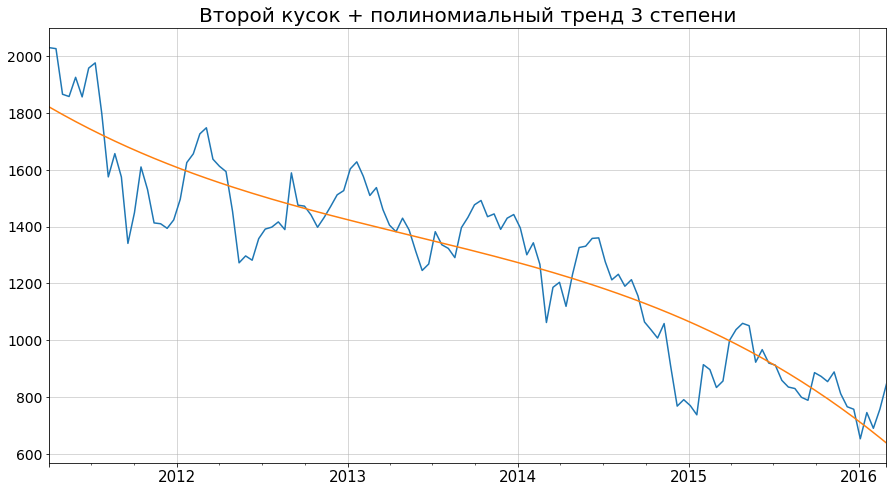

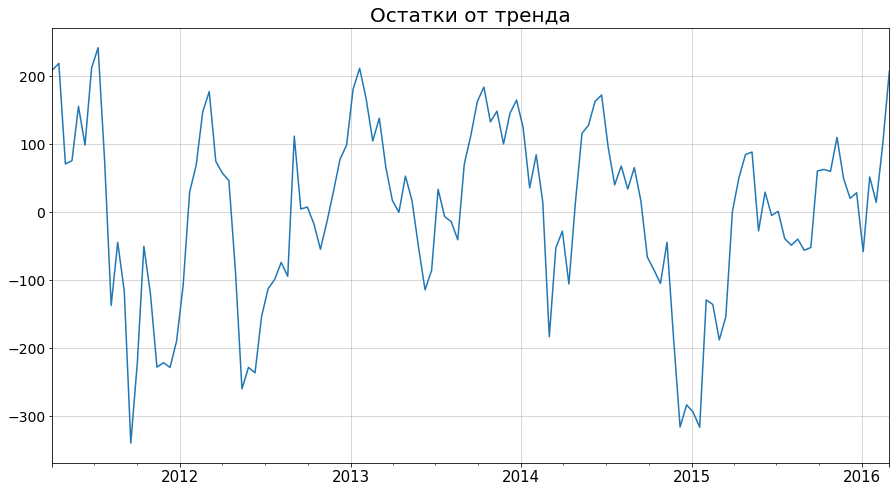

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     219.5
Date:                Fri, 08 May 2020   Prob (F-statistic):           1.25e-49
Time:                        01:28:19   Log-Likelihood:                -810.60
No. Observations:                 129   AIC:                             1629.
Df Residuals:                     125   BIC:                             1641.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1834.4483     47.763     38.407      0.000    1739.919    1928.977
x1           -13.5544      3.170     -4.276      0.000     -19.827      -7.281
x2             0.1411      0.057      2.495      0.014       0.029       0.253
x3            -0.0008      0.000     -2.925      0.004      -0.001      -0.000
==============================================================================
Omnibus:                        6.084   Durbin-Watson:                   0.370
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                6.278
Skew:                          -0.530   Prob(JB):                       0.0433
Kurtosis:                       2.785   Cond. No.                     3.39e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.39e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [158]:
partial_series.p2.plot()
partial_series.p2.polynomial_trend(3).plot()
plt.title('Второй кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p2.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p2.polynomial_trend(3).fitted_model.summary())

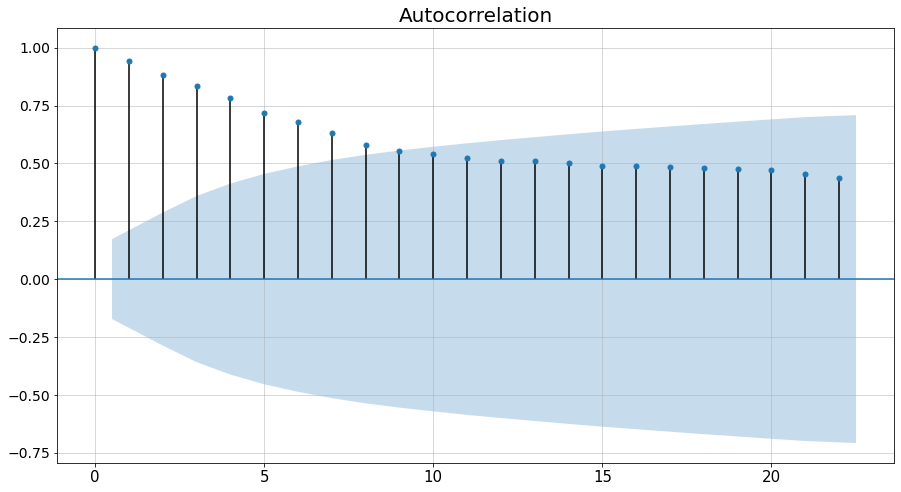

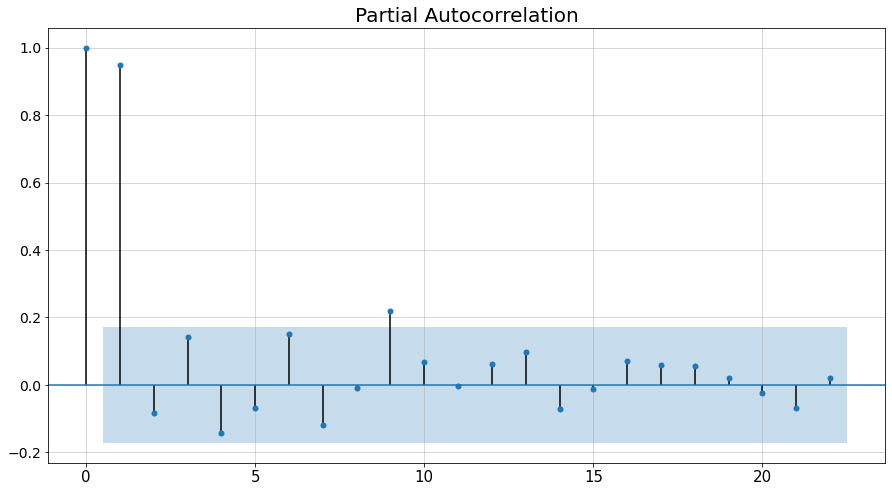

In [159]:
plot_acf(partial_series.p2)
plot_pacf(partial_series.p2);

In [173]:
rss2 = ((partial_series.p2.polynomial_trend(3) - partial_series.p2.mean())**2).sum()

### 3-ий кусок

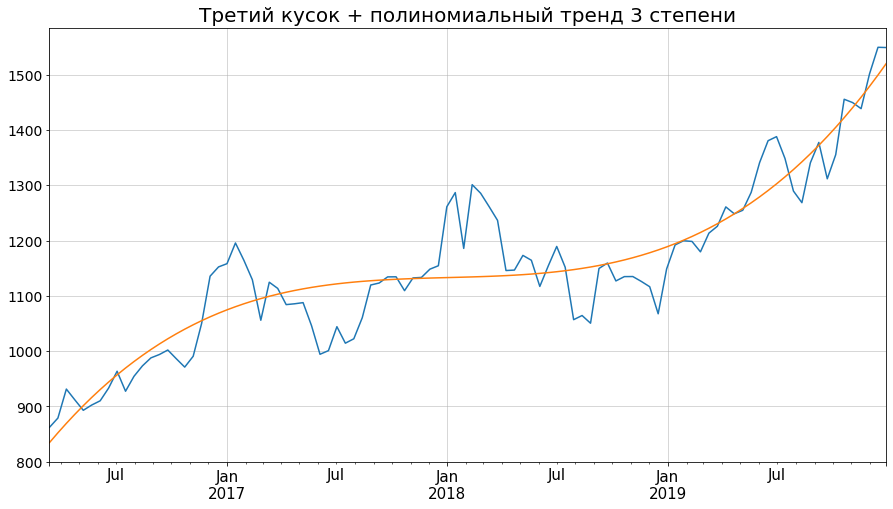

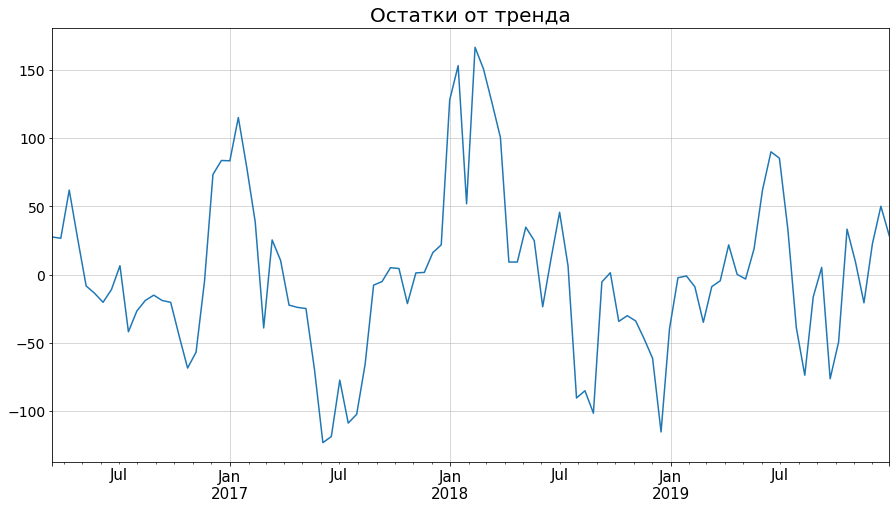

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     172.3
Date:                Fri, 08 May 2020   Prob (F-statistic):           1.64e-38
Time:                        00:33:01   Log-Likelihood:                -550.01
No. Observations:                 100   AIC:                             1108.
Df Residuals:                      96   BIC:                             1118.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        816.1133     25.110     32.502      0.000     766.271     865.956
x1            18.9131      2.142      8.828      0.000      14.661      23.166
x2            -0.3837      0.049     -7.805      0.000      -0.481      -0.286
x3             0.0026      0.000      8.280      0.000       0.002       0.003
==============================================================================
Omnibus:                        5.162   Durbin-Watson:                   0.476
Prob(Omnibus):                  0.076   Jarque-Bera (JB):                4.494
Skew:                           0.458   Prob(JB):                        0.106
Kurtosis:                       3.491   Cond. No.                     1.60e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [120]:
partial_series.p3.plot()
partial_series.p3.polynomial_trend(3).plot()
plt.title('Третий кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p3.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p3.polynomial_trend(3).fitted_model.summary())

In [175]:
rss3 = ((partial_series.p3.polynomial_trend(3) - partial_series.p3.mean())**2).sum()

In [126]:
partial_series_p3_remains = partial_series.p3.polynomial_trend(3).fitted_model.resid

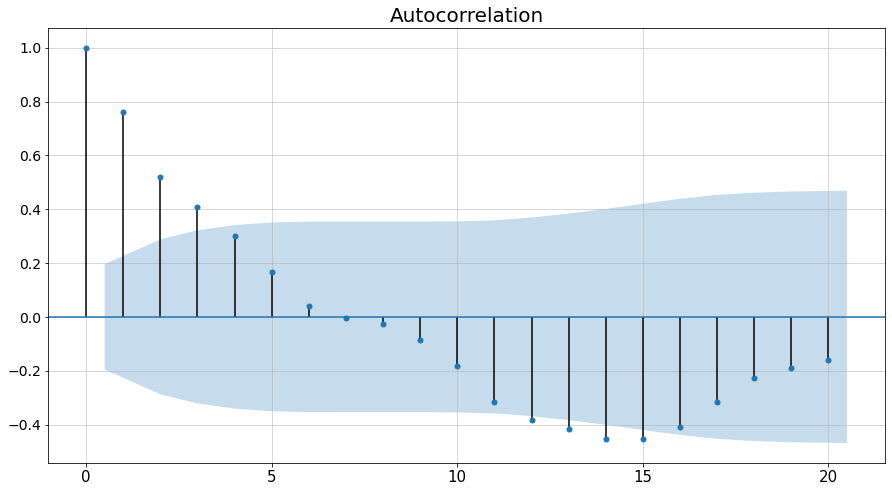

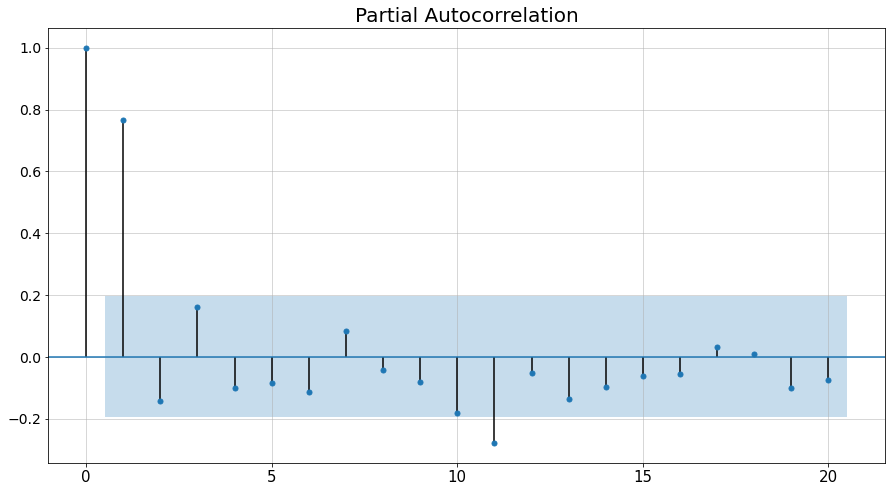

In [130]:
plot_acf(partial_series_p3_remains)
plot_pacf(partial_series_p3_remains);

In [135]:
order = (2, 0, 3)
# order = Arima.find_optimal_model_by_order(partial_series_p3_remains, (1, 2, 3), 0, (1, 2, 3, 4)).order
arima_by_partial_series_p3_remains = ARIMA(partial_series_p3_remains, order=order)
arima_by_partial_series_p3_remains_fitted_model = arima_by_partial_series_p3_remains.fit()

Перебрал 12 вариант(а/ов) за 3.44 сек.


In [136]:
arima_by_partial_series_p3_remains_fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                     ARMA(2, 3)   Log Likelihood                -499.208
Method:                       css-mle   S.D. of innovations             34.854
Date:                Fri, 08 May 2020   AIC                           1012.416
Time:                        00:40:23   BIC                           1030.652
Sample:                    03-13-2016   HQIC                          1019.796
                         - 12-29-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7735      1.672      0.463      0.644      -2.504       4.051
ar.L1.y        1.8804      0.055     34.255      0.000       1.773       1.988
ar.L2.y       -0.9149      0.052    -17.602      0.000      -1.017      -0.813
ma.L1.y       -1.1362      0.126     -8.988      0.000      -1.384      -0.888
ma.L2.y       -0.2504      0.145     -1.727      0.084      -0.535       0.034
ma.L3.y        0.3866      0.122      3.175      0.001       0.148       0.625
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0276           -0.1923j            1.0455           -0.0294
AR.2            1.0276           +0.1923j            1.0455            0.0294
MA.1           -1.7940           +0.0000j            1.7940            0.5000
MA.2            1.0000           +0.0000j            1.0000            0.0000
MA.3            1.4418           +0.0000j            1.4418            0.0000
-----------------------------------------------------------------------------
"""

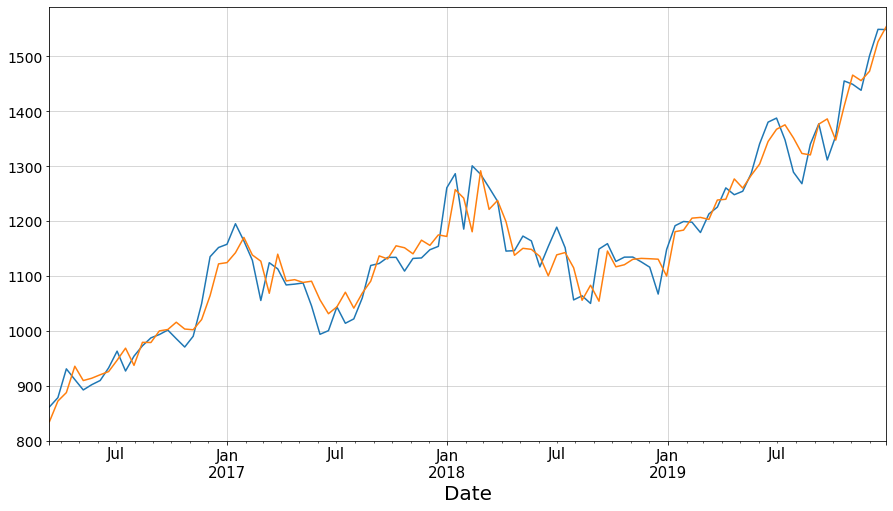

In [142]:
partial_series.p3.plot()
(partial_series.p3.polynomial_trend(3).series + arima_by_partial_series_p3_remains_fitted_model.fittedvalues).plot()

In [147]:
mae(
    partial_series.p3,
    partial_series.p3.polynomial_trend(3).series + arima_by_partial_series_p3_remains_fitted_model.fittedvalues
)

26.844933912842645

### Выведем склеенный тренд и применим на все остатки ARIMA

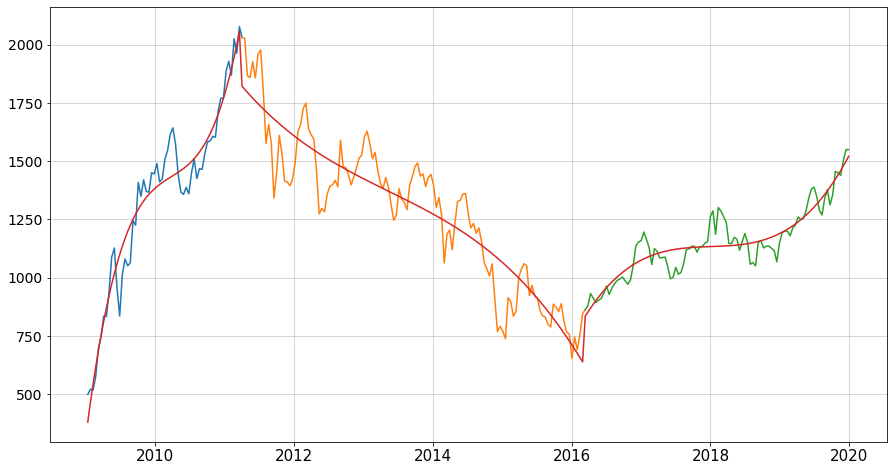

In [191]:
draw(partial_series);
partial_series_trend = (
    partial_series.p1.polynomial_trend(3)
    .append(partial_series.p2.polynomial_trend(3))
    .append(partial_series.p3.polynomial_trend(3))
)
partial_series_trend_remains = (series - partial_series_trend)
draw(partial_series_trend);

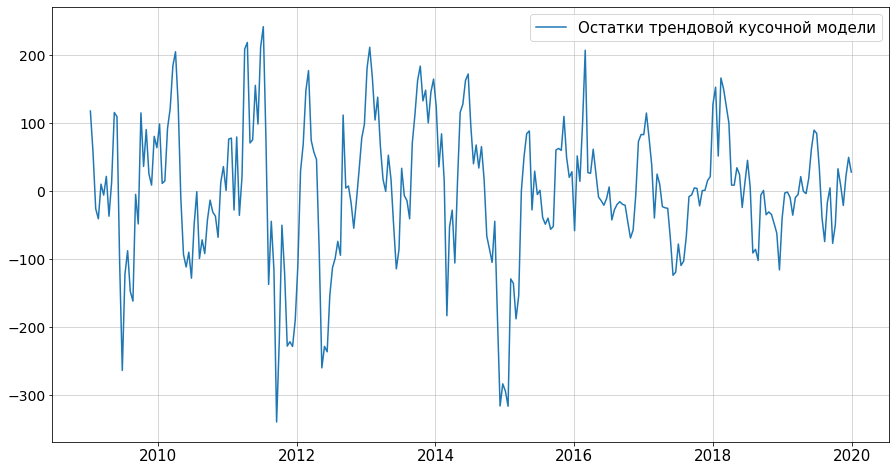

In [215]:
draw(partial_series_trend_remains);
plt.legend(['Остатки трендовой кусочной модели'])
plt.show()

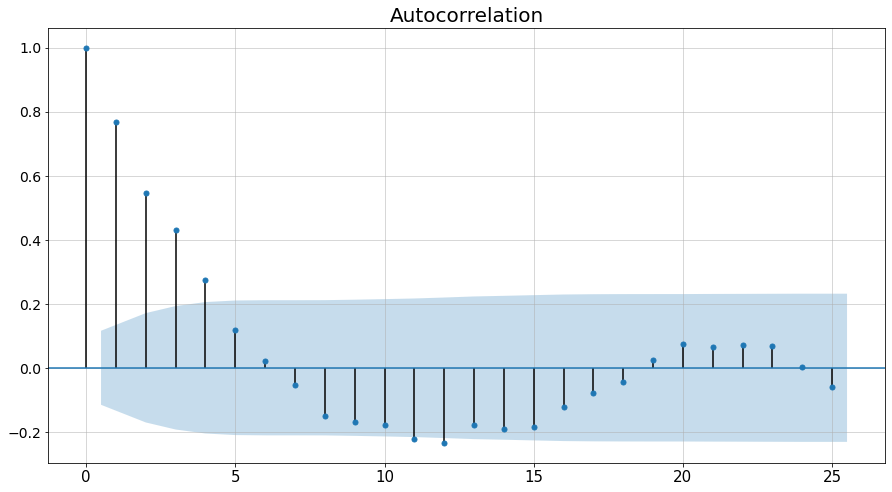

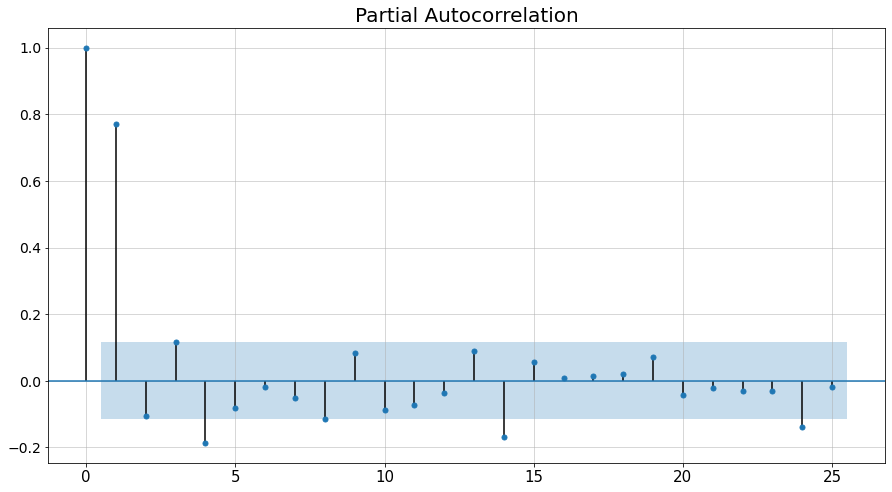

In [217]:
plot_acf(partial_series_trend_remains)
plot_pacf(partial_series_trend_remains);

In [226]:
# _ = Arima.find_optimal_model_by_order(partial_series_trend_remains, range(1, 5), 0, range(1, 5), top=16)

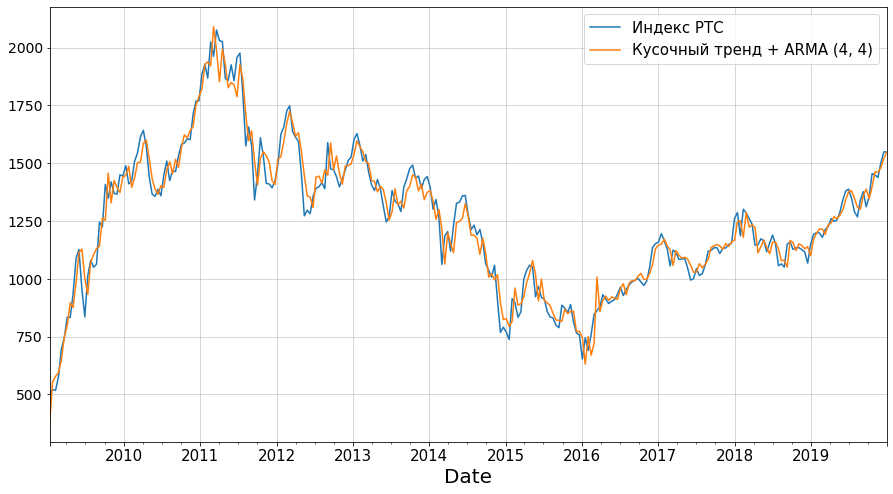

In [235]:
arima_by_partial_series_trend_remains = ARIMA(partial_series_trend_remains, order=(4, 0, 4)).fit()
series.plot();
(partial_series_trend + arima_by_partial_series_trend_remains.fittedvalues).plot();
plt.legend(['Индекс РТС', 'Кусочный тренд + ARMA (4, 4)'])
plt.show()

In [224]:
arima_by_partial_series_trend_remains.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  287
Model:                     ARMA(4, 4)   Log Likelihood               -1587.246
Method:                       css-mle   S.D. of innovations             60.575
Date:                Fri, 08 May 2020   AIC                           3194.493
Time:                        02:19:26   BIC                           3231.087
Sample:                    01-11-2009   HQIC                          3209.159
                         - 12-29-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2754      1.525      0.181      0.857      -2.714       3.265
ar.L1.y        1.0983      0.072     15.166      0.000       0.956       1.240
ar.L2.y       -0.5683      0.106     -5.384      0.000      -0.775      -0.361
ar.L3.y        1.1256      0.075     14.942      0.000       0.978       1.273
ar.L4.y       -0.7265      0.053    -13.626      0.000      -0.831      -0.622
ma.L1.y       -0.2650      0.094     -2.813      0.005      -0.450      -0.080
ma.L2.y        0.1595      0.081      1.969      0.049       0.001       0.318
ma.L3.y       -0.8206      0.073    -11.292      0.000      -0.963      -0.678
ma.L4.y       -0.0737      0.095     -0.774      0.439      -0.260       0.113
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3499           -0.9743j            1.0353           -0.3049
AR.2           -0.3499           +0.9743j            1.0353            0.3049
AR.3            1.1246           -0.1402j            1.1333           -0.0197
AR.4            1.1246           +0.1402j            1.1333            0.0197
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.3862           -1.0222j            1.0928           -0.3075
MA.3           -0.3862           +1.0222j            1.0928            0.3075
MA.4          -11.3628           -0.0000j           11.3628           -0.5000
-----------------------------------------------------------------------------
"""

### Прогноз

In [236]:
params = partial_series.p3.polynomial_trend(3).fitted_model.params
params

const    816.113301
x1        18.913095
x2        -0.383668
x3         0.002650
dtype: float64

In [237]:
__ = []
for i in range(106):
    __.append(params.const + params.x1*i + params.x2 * i**2 + params.x3*i**3)

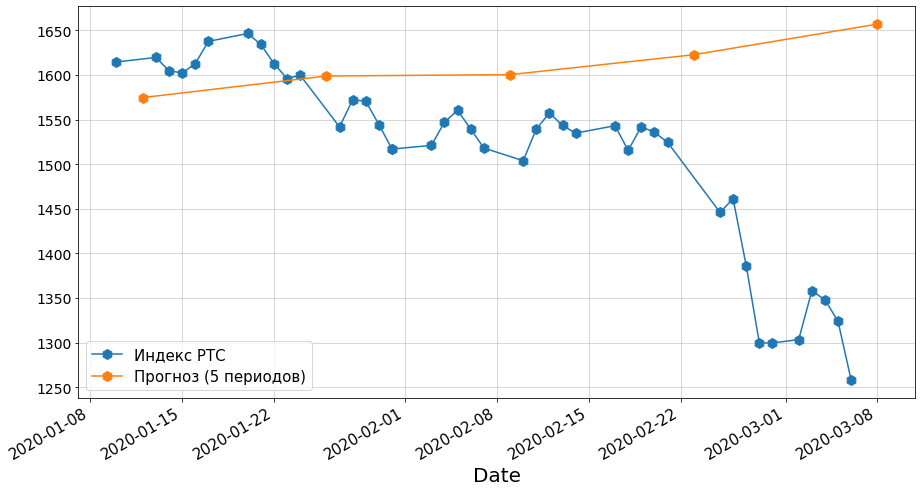

In [254]:
series2020['2020-01-10':'2020-03-06'].plot(marker='h', markersize=10, label='Индекс РТС')
plt.plot((arima_by_partial_series_trend_remains.predict('2020', '2020-03') + __[-5:]), marker='h', markersize=10)
plt.legend(['Индекс РТС', 'Прогноз (5 периодов)'])
plt.show()

In [239]:
r2_score(
    (arima_by_partial_series_trend_remains.predict('2020', '2020-03') + __[-5:]),
    ser1
)

NameError: name 'ser1' is not defined

# Holt-Winters

In [ ]:
holt_winters = ExponentialSmoothing(series, seasonal_periods=9, trend='add', seasonal='mul', damped=True).fit()
holt_winters.summary()

In [ ]:
series.plot()
holt_winters.fittedvalues.plot();

In [ ]:
Model(series).aic(holt_winters.fittedvalues, 5)

In [ ]:
holt_winters.forecast(4)

### Оценивание точности

In [144]:
def mape(other1, other):
    """ Критерий MAPE """
    return np.mean(np.abs((other1 - other) / other1)) * 100

def mae(other1, other):
    """ Критерий MAE """
    return np.mean(np.abs(other1 - other))

##### ARIMA (тренд + ARIMA на остатки)

In [ ]:
print(mape(series, series_trend + arima_by_series_remains.fittedvalues))
print(mae(series, series_trend + arima_by_series_remains.fittedvalues))
r2_score(series, series_trend + arima_by_series_remains.fittedvalues)

##### ARIMA на исходные данные

In [ ]:
print(mape(series, series - arima_by_series.resid))
print(mae(series, series - arima_by_series.resid))
r2_score(series.iloc[1:], (series - arima_by_series.resid).iloc[1:])

##### ARIMA с CHOW TEST

In [ ]:
print(mape(series, (partial_series_trend + arima_by_partial_series_trend_remains.fittedvalues)))
print(mae(series, (partial_series_trend + arima_by_partial_series_trend_remains.fittedvalues)))
r2_score(series, (partial_series_trend + arima_by_partial_series_trend_remains.fittedvalues))

##### ARIMAX с факторами из регрессионого анализа

In [ ]:
print(mape(test_df2.RTSI, arimax.fittedvalues))
print(mae(test_df2.RTSI, arimax.fittedvalues))
r2_score(test_df2.RTSI, arimax.fittedvalues)

##### Holt-Winters

In [ ]:
print(mape(series, holt_winters.fittedvalues))
print(mae(series, holt_winters.fittedvalues))
r2_score(series, holt_winters.fittedvalues)

# ARX-GARCH модель

In [ ]:
week_series = df['2009-01':'2019'].Close
week_series = week_series.resample('14d').last()

ar_by_week_series = ARX(week_series.to_numpy(), test_df2['Brent'].resample('14d').last().to_numpy()[:, np.newaxis], lags=1)
ar_by_week_series_fitted = ar_by_week_series.fit()
display(ar_by_week_series_fitted.summary())

argarch_by_week_series = ar_by_week_series
argarch_by_week_series.volatility = GARCH(p=1, q=1)
argarch_by_week_series_fitted = argarch_by_week_series.fit()
argarch_by_week_series_fitted.summary()

In [ ]:
week_series = df['2009':'2019'].Close
week_series = week_series.resample('14d').last()

ar_by_week_series = ARX(week_series.to_numpy(), lags=1)
ar_by_week_series_fitted = ar_by_week_series.fit()
display(ar_by_week_series_fitted.summary())

argarch_by_week_series = ar_by_week_series
argarch_by_week_series.volatility = GARCH(p=1, q=1)
argarch_by_week_series_fitted = argarch_by_week_series.fit()
argarch_by_week_series_fitted.summary()

In [ ]:
argarch_by_week_series_fitted.plot();

In [ ]:
week_series.plot()
(week_series - argarch_by_week_series_fitted.resid).plot();

In [ ]:
print(mape(week_series, (week_series - argarch_by_week_series_fitted.resid)))
mae(week_series, (week_series - argarch_by_week_series_fitted.resid))

In [ ]:
q = argarch_by_week_series_fitted.forecast(horizon=3, method='simulation', simulations=1_000).simulations.values

In [ ]:
_ = []
for i in q[-1]:
    _.extend(i)
    plt.plot(
        range(len(week_series) + len(i))[:],
        np.append(week_series.to_list(), _)[:]
    )
    _.clear()

In [ ]:
sns.boxplot(data=q[-1]);

# VAR + GARCH модель

In [ ]:
# week_series_changed = arch.data.sp500.load()['Adj Close'].pct_change().dropna() * 100
week_series_changed = df['2009':'2019'].Close
week_series_changed = week_series_changed.resample('13d').last()

week_series_changed = week_series_changed.pct_change().dropna()
am = arch_model(week_series_changed, vol='Garch', p=1, o=0, q=1, dist='Normal')
res = am.fit(disp='off', last_obs='2014-12-31')

forecasts = res.forecast(start='2015-1-1')
cond_mean = forecasts.mean['2015':]
cond_var = forecasts.variance['2015':]
q = am.distribution.ppf([0.01, 0.05])
print(q)

value_at_risk = cond_mean.values + np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(
    value_at_risk, columns=['1%', '5%'], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = week_series_changed['2015':].copy()
rets_2018.name = 'RTS return'
c = []


for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2018[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
c = np.array(c, dtype='object')
labels = {
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}
markers = {'#BB0000': 'o', '#BB00BB': 's', '#000000': 'x'}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
    )
ax.set_title('Parametric VaR')
leg = ax.legend(frameon=False, ncol=3)